In [1]:
from fastai.vision import *
from sklearn.model_selection import train_test_split

from fastai_bayesian.custom_dropout import CustomDropout, switch_custom_dropout, convert_layers
from fastai_bayesian.metrics import (entropy, BALD, uncertainty_best_probability,
                      get_preds_sample, plot_hist_groups, top_k_uncertainty)

import seaborn as sns

In [2]:
class ImageActiveLearner:
    def __init__(self,path,train_df,get_model,acq_fn=None,label_fn=None,**kwargs):
        """Initialiaze the Learner with the train and test data, and create it with the given params. 
        data_params are the parameters of the TabularDatabunch.
        learn_params are the parameters of the tabular learner other than the Databunch.
        acq_fn is the acq_fn to use. Its signature is :
        acq_fn(learn:Learner,k)
        
        label_fn()
        
        """
        self.path = path
        
        # We store the functions we will use
        self.acq_fn = acq_fn
        self.label_fn = label_fn
        self.get_model = get_model
        
        # Create the Learner
        self.add_learn(train_df,**kwargs)
    
    @classmethod
    def create_databunch(cls,df,valid_pct = 0.2,bs = 32,size = 28,gray = True):
        path = Path("/")

        tfms = get_transforms(do_flip = False)

        data = (ImageList.from_df(df,path)
                .split_by_rand_pct(valid_pct=valid_pct,seed=42)
                .label_from_df()
                .transform(tfms,size = size)
                .databunch(bs = bs)
                .normalize())

        def get_one_channel(batch):
            x,y = batch
            return x[:,0,:,:].unsqueeze(1),y
        get_one_channel._order = 99

        if gray:
            data.add_tfm(get_one_channel)
        data.path = Path()

        return data
        
    def add_learn(self,train_df,**kwargs):

        # Create a Learner 
        path = self.path
        train_data = ImageActiveLearner.create_databunch(df=train_df, **kwargs)
        model = self.get_model()
        learn = Learner(train_data,model,metrics=accuracy)
        
        # Add the Custom Dropout to do MC Dropout
        get_args = lambda dp : {"p" : dp.p}
        convert_layers(learn.model,nn.Dropout,CustomDropout,get_args)
        switch_custom_dropout(learn.model,True)
        
        self.learn = learn
        
    def fit(self,n_epoch,lr):
        """Train the model using one cycle policy and with the training params"""
        n_epoch = listify(n_epoch)
        lr = listify(lr)
        
        for n,l in zip(n_epoch,lr):
            self.learn.fit_one_cycle(n, l)
    
    def inspect(self):
        """Inspect the results of the learning"""
        pass
    
    def acquire(self,acq_df,k,bs=512):
        """Get indexes of the k most interesting labels to acquire from the test set"""
        
        # We add a acquisition Databunch
        acq_data = ImageActiveLearner.create_databunch(df=acq_df, valid_pct=0.,bs=bs)
        idx = self.acq_fn(self.learn,acq_data,k)
        
        return idx
    
    def validate(self,metric,test_df,bs=512,MC_dropout=False):
        """Return a validation score on the test set"""
        learn = self.learn
        
        test_data = ImageActiveLearner.create_databunch(df=test_df, valid_pct=0.,bs=bs)
        
        learn.data = test_data
        
        if MC_dropout:
            preds,y = get_preds_sample(learn,DatasetType.Fix)
            pred = preds.mean(dim=0)
        else:
            pred,y = learn.get_preds(DatasetType.Fix)
        
        score = metric(pred,y)
        return score
        
    def label(self,idx,acq_df):
        """Label the indexes of the acquisition dataset"""
        df_to_label = acq_df.iloc[idx]        
        labeled_df = self.label_fn(df_to_label)
        return labeled_df
    
    @classmethod
    def transfer_rows(cls,train_df,acq_df,idx):
        """Transfer the rows of the acq_df to the train_df"""
        rows = acq_df.iloc[idx]

        train_df = pd.concat([train_df,rows])
        acq_df = acq_df.drop(acq_df.index[idx])
        
        return train_df, acq_df

In [3]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1,32,kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3),
        nn.ReLU(),
        nn.AdaptiveMaxPool2d((2,2)),
        CustomDropout(p=0.25),
        nn.Flatten(),
        nn.Linear(256,128),
        nn.ReLU(),
        CustomDropout(0.5),
        nn.Linear(128,10)
    )
    return model

In [4]:
# Acquisition functions 
def get_top_samples(learn,acq_data,k,metric):
    learn.data = acq_data
    preds,_ = get_preds_sample(learn,DatasetType.Fix)
    scores = metric(preds)
    d = dict(zip(np.arange(len(scores)),scores))
    idx = sorted(d,key = d.get,reverse=True)[:k]
    
    return idx

def get_random_idx(learn,acq_data,k):
    n = len(acq_data.train_ds)
    idx = np.random.choice(np.arange(n),k,replace=False)
    return idx

top_bald = partial(get_top_samples,metric=BALD)
top_entropy = partial(get_top_samples,metric=entropy)

label = lambda x: x

In [5]:
def train_test_split_image(train_size):
    # Create two data bunchs, one for training the unsupervised model, one for testing
    # the results of the semi supervised model
    
    # We first load the whole data set 
    path = untar_data(URLs.MNIST)
    tfms = get_transforms(do_flip = False)
    data = (ImageList.from_folder(path/"training")
            .split_none()
            .label_from_folder()
            .transform()
            .databunch())

    # We then randomly select train_size samples from the whole MNIST and put in train
    # for the unsupervised, and semi supervised training, and the rest will be used 
    # as a test set for the semi supervised model evaluation
    
    n = len(data.train_ds.x.items)
    
    # We create two data frames which will be used to create the data bunches
    train_idx = np.random.choice(n,train_size,replace = False)
    x_train,y_train = data.train_ds.x.items[train_idx],data.train_ds.y.items[train_idx]
    train_df = pd.DataFrame({"name":x_train,"label":y_train})
    
    test_idx = np.array(list(set(np.arange(n)) - set(train_idx)))
    x_test,y_test = data.train_ds.x.items[test_idx],data.train_ds.y.items[test_idx]
    test_df = pd.DataFrame({"name" : x_test,"label":y_test})
    
    return train_df, test_df

In [14]:
path = untar_data(URLs.MNIST)

In [15]:
# total_train_size = 50000

# init_train_df, test_df = train_test_split_image(total_train_size)

# train_size = 320
# init_train_df, init_acq_df = train_test_split(init_train_df,train_size=train_size,random_state=42)

# init_acq_df.to_csv("init_acq_df.csv",index=None)
# init_train_df.to_csv("init_train_df.csv",index=None)
# test_df.to_csv("test_df.csv",index=None)

In [16]:
init_acq_df = pd.read_csv("init_acq_df.csv")
init_train_df = pd.read_csv("init_train_df.csv")
test_df = pd.read_csv("test_df.csv")

In [17]:
n_runs = 3
n_cycle = 20
k = 40
outputs = []

acq_fn = top_bald
acq_name= "bald"
label_fn = lambda x : x

for t in range(n_runs):
    train_df = init_train_df.copy()
    acq_df = init_acq_df.copy()

    active_learn = ImageActiveLearner(Path(),train_df,get_model=get_model
                                      ,acq_fn=acq_fn,label_fn=label_fn)
    
    for i in range(n_cycle):
        active_learn.fit(15,1e-2)

        score = active_learn.validate(accuracy,test_df,MC_dropout=True).item()
        
        idx = active_learn.acquire(acq_df,k=32)

        labeled_df = active_learn.label(idx,acq_df)

        train_df, acq_df = active_learn.transfer_rows(train_df,acq_df,idx)
        active_learn.add_learn(train_df)
        
        output = {"i":i,"score":score,"acq_name":acq_name}
        outputs.append(output)

Current active : True
Switching to : True
Current active : True
Switching to : True


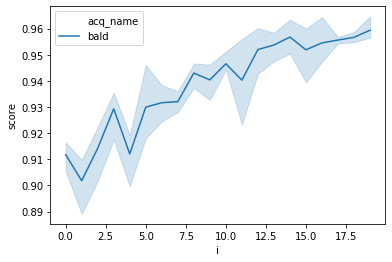

In [18]:
import seaborn as sns
results = pd.DataFrame(outputs)
sns.lineplot(x="i",y="score",hue="acq_name",data=results)

In [19]:
results.to_csv("results_MNIST.csv",index=None)

In [20]:
n_runs = 3
n_cycle = 20
k = 40
outputs = []

acq_fn = get_random_idx
acq_name= "random"
label_fn = lambda x : x

for t in range(n_runs):
    train_df = init_train_df.copy()
    acq_df = init_acq_df.copy()

    active_learn = ImageActiveLearner(Path(),train_df,get_model=get_model
                                      ,acq_fn=acq_fn,label_fn=label_fn)
    
    for i in range(n_cycle):
        active_learn.fit(15,1e-2)

        score = active_learn.validate(accuracy,test_df,MC_dropout=True).item()
        
        idx = active_learn.acquire(acq_df,k=32)

        labeled_df = active_learn.label(idx,acq_df)

        train_df, acq_df = active_learn.transfer_rows(train_df,acq_df,idx)
        active_learn.add_learn(train_df)
        
        output = {"i":i,"score":score,"acq_name":acq_name}
        outputs.append(output)

Current active : True
Switching to : True
Current active : True
Switching to : True


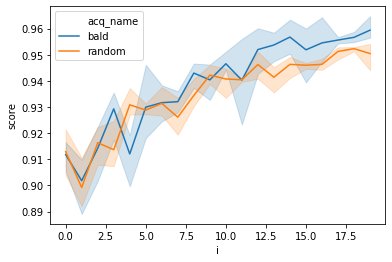

In [21]:
new_results = pd.DataFrame(outputs)
results = pd.concat([results,new_results])
sns.lineplot(x="i",y="score",hue="acq_name",data=results)

In [22]:
results.to_csv("results.csv",index=None)

In [23]:
n_runs = 3
n_cycle = 20
k = 40
outputs = []

acq_fn = top_entropy
acq_name= "entropy"
label_fn = lambda x : x

for t in range(n_runs):
    train_df = init_train_df.copy()
    acq_df = init_acq_df.copy()

    active_learn = ImageActiveLearner(Path(),train_df,get_model=get_model
                                      ,acq_fn=acq_fn,label_fn=label_fn)
    
    for i in range(n_cycle):
        active_learn.fit(15,1e-2)

        score = active_learn.validate(accuracy,test_df,MC_dropout=True).item()
        
        idx = active_learn.acquire(acq_df,k=32)

        labeled_df = active_learn.label(idx,acq_df)

        train_df, acq_df = active_learn.transfer_rows(train_df,acq_df,idx)
        active_learn.add_learn(train_df)
        .
        output = {"i":i,"score":score,"acq_name":acq_name}
        outputs.append(output)

Current active : True
Switching to : True
Current active : True
Switching to : True


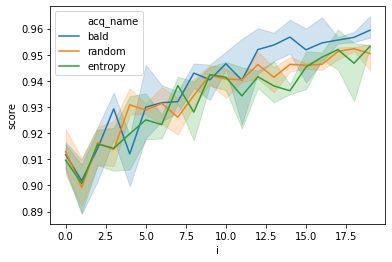

In [24]:
new_results = pd.DataFrame(outputs)
results = pd.concat([results,new_results])
sns.lineplot(x="i",y="score",hue="acq_name",data=results)

In [25]:
results.to_csv("results.csv",index=None)